레퍼런스 자료를 참고하여 번역 및 차량파손탐지 custom dataset을 위해 간소화 시킨 노트북입니다.

# 1. Clone Darknet

- Darknet을 사용하기 위해 clone 후 makefile을 수정해주고 빌드하는 과정입니다.

In [1]:
# Darknet 레포 clone하기
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15283, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 15283 (delta 40), reused 50 (delta 26), pack-reused 15186
Receiving objects: 100% (15283/15283), 13.78 MiB | 24.37 MiB/s, done.
Resolving deltas: 100% (10351/10351), done.


In [2]:
# makefile에서 GPU와 OPENCV 설정하기 (다운받아서 직접 1로 고쳐준 뒤 업로드 해도 됩니다.)
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [3]:
# gpu 확인
!nvidia-smi

Wed Jul 21 13:47:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [5]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# 2. Download pretrained YOLOv3 weights

- coco 데이터셋을 이용해서 80개의 class로 학습된 Yolov3의 사전학습 가중치를 이용해서 바로 예측이 가능합니다.

In [6]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-07-21 13:49:07--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  75.1MB/s    in 3.2s    

2021-07-21 13:49:11 (74.5 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



## 파일 업로드, 다운로드, 이미지 show를 위한 사전 함수 정의

In [7]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline
  

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

# 3. Uploading Local or Google Drive Files to Use

- 사전학습된 모델로 object detection 또는 자기가 가진 이미지 데이터를 학습시킨 후 예측할 수 있습니다. 이를 위해 구글 드라이브에 올리는 과정

아래의 Darknet 커맨드를 이용해서 사전학습 모델로 이미지 예측이 가능합니다.
```
!./darknet detect cfg/yolov3.cfg yolov3.weights /mydrive/<path to image>
```
* 구글 드라이브 root 단계에 images란 폴더에 이미지 저장하는 것을 추천

In [8]:
# 구글 드라이브 마운트
# 지금 darknet에 위치하고 있으므로 전 디렉토리로 이동 후 마운트
%cd .. 
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [9]:
# /content/gdrive/My\ Drive/ 라는 긴 주소를 /mydrive로 줄여줄 수 있음.
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [10]:
# images 폴더에 이미지 파일을 넣어준 뒤 커맨드를 입력하면 예측할 수 있음
%cd darknet
# !./darknet detect cfg/yolov3.cfg yolov3.weights /mydrive/images/cat_dog.jpg
# imShow('predictions.jpg')

/content/darknet


### Download Files to Local Machine or Google Drive from Cloud VM 

1. 로컬
- 사전에 정의한 'download()' 함수를 사용하거나, 파일 우클릭으로 predictions.jpg 파일을 다운받을 수 있다.

2. Google Drive
- 아래 명령어를 통해서 구글 드라이브의 파일을 원하는 디렉토리로 다운(copy)할 수 있다.

```
!cp <file to download> <destination to save file>
```

In [13]:
# LOCAL MACHINE DOWNLOAD
# download('predictions.jpg')

In [15]:
# GOOGLE DRIVE DOWNLOAD
# 다운로드 할 때 이름 변경 가능하다.
# !cp predictions.jpg /mydrive/images/detection1.jpg

# 4. Training a Custom YOLOv3 Object Detector

차량 파손 이미지 데이터를 Yolov3 모델에 학습시키는 과정

직접 학습시기기 위해서는 아래 과정이 필요하다.

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)


## Step 1: Gathering and Labeling a Custom Dataset

### 방법 1: 구글 Open Images Dataset 이용 (RECOMMENDED)
구글 데이터셋에서 받아온 뒤 OIDv4 toolkit을 사용하면 쉽게 label을 만들 수 있다. [Explore the Dataset Here!](https://storage.googleapis.com/openimages/web/index.html)

데이터셋 만드는 방법 참고
[Creating a Custom YOLOv3 Dataset (Video)](https://www.youtube.com/watch?v=_4A9inxGqRM)

OIDv4 toolkit 깃허브 레포 [OIDv4_ToolKit](https://github.com/theAIGuysCode/OIDv4_ToolKit)

### 방법 2: 직접 Label 분류
차량 파손 이미지에 대해 내가 이미 가진 데이터가 있었고, scratch, dent, spacing이라는 것을 자동으로 분류하기 힘들 것이라 생각해서 직접 class를 나눴다.

이미지 Label 참고영상
[Create Labels and Annotations for Custom YOLOv3 Dataset (Video)](https://www.youtube.com/watch?v=EGQyDla8JNU)

[Labellmg 다운 링크](https://tzutalin.github.io/labelImg/) 


설치하면 다음과 같이 labeling이 가능하다.

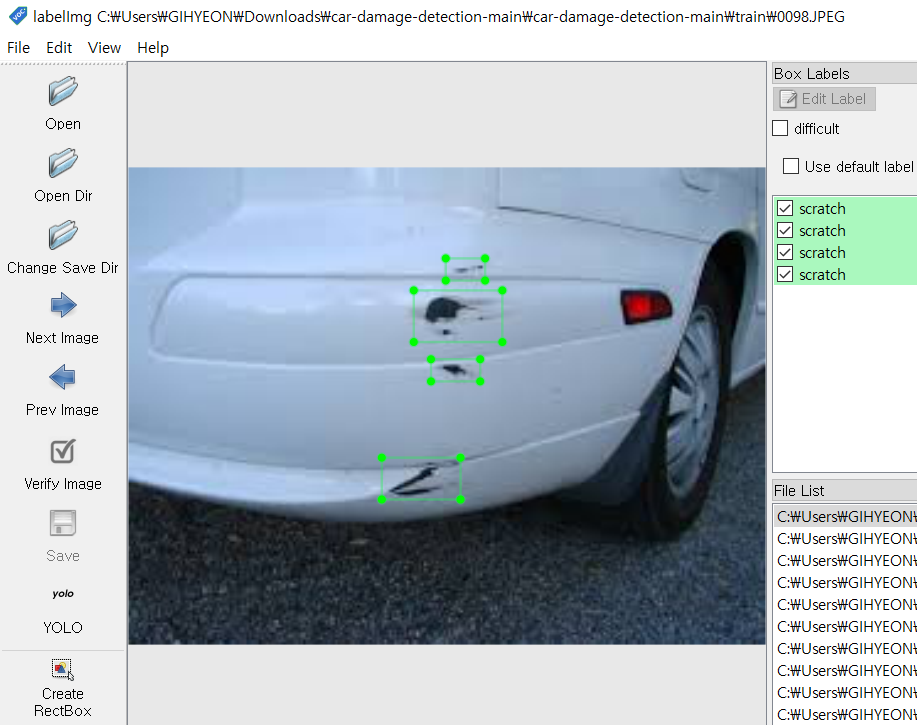

label이 끝나면 해당 폴더에 이런 classes.txt 파일이 만들어진다.

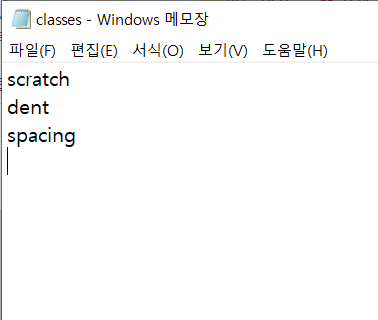

## Step 2: Moving Your Custom Dataset Into Your Cloud VM

로컬에 저장된 labeled 된 이미지 폴더를 obj로 바꿔주고 zip파일로 구글 드라이브에 업로드 해준 뒤 코랩에서 unzip해주면 빠르게 파일 사용이 가능하다.

In [ ]:
# 구글 드라이브에 yolov3 폴더를 만들고 업로드 해준 상태
# !ls /mydrive/yolov3

In [ ]:
# zip파일을 코랩 root directory로 다운(copy) 
# !cp /mydrive/yolov3/obj.zip ../

In [ ]:
# 현재 위치는 darknet이기 때문에 root directory의 obj.zip을 darknet의 data폴더에 unzip해준다. (/darknet/data/obj 안에 파일들 생성)
# !unzip ../obj.zip -d data/

## Step 3: Configuring Files for Training
custom data를 학습하기 위해서 다음 4개의 파일 구성이 필요하다 custom.cfg file, obj.data, obj.names and train.txt file.

커스텀 파일 구성 방법 참고 [Configuring YOLOv3 Files for Training](https://www.youtube.com/watch?v=zJDUhGL26iU&t=300s)



### i) Cfg File

- cfg폴더의 yolov3.cfg파일을 다운받아서 몇 가지 수정을 해줘야 한다.

Test에 주석을 달아주고, Train에 주석의 해제한 뒤 **batch**와 **subdivisions**을 조절한다.
**batch = 64**, **subdivisions = 16**로 하는 것을 추천하고, 이슈가 발생하면 **subdivisions = 32**로 변경하는 것을 권하고있다.

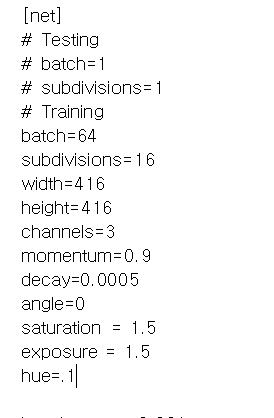



**Note:** **max_batches = 6000**, **steps = 4800, 5400**으로 설정해줬다.

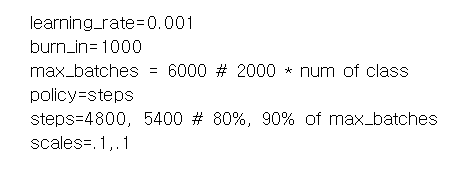

max_batches는 class의 개수 * 2000으로, steps는 max_batches의 80%와 90%로 설정하는 것을 추천하고있다.



 그리고 3개의 yolo 부분을 찾아서 **classes = 3** 으로 바꿔주고 convolutional부분에서  **filters = 24**로 바꿔준다. filters는 (class의 개수 + 5) * 3으로 한다.

 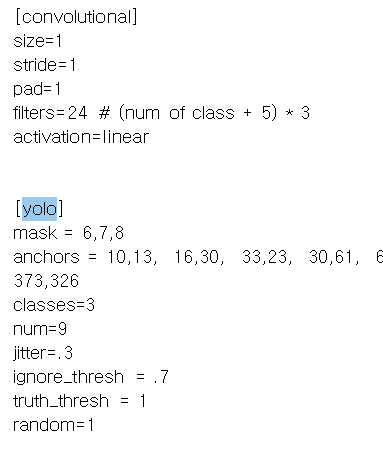  

**Optional:** random = 1 을 **random = 0** 으로 바꿔주면 속도는 올라가지만 정확도는 떨어질 수 있다. 메모리 문제가 발생할 경우 바꿔주면 된다.


In [11]:
# 현재 위치가 darknet이어야 한다.
%pwd

'/content/darknet'

In [12]:
# custom한 .cfg 파일을 darkner/cfg 폴더에 넣어준다.
!cp /content/gdrive/MyDrive/data/car_damage_detection/yolov3_custom.cfg ./cfg

# 로컬에서 업로드 할 경우
#%cd cfg
#upload()
#%cd .. 

### ii) obj.names and obj.data 

classes.txt 파일을 **obj.names** 파일로 바꿔준다.

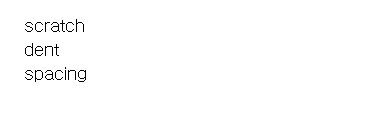

image.png


아래와 같이 **obj.data** 파일도 하나 만들어 준다. (class 수와 가중치 백업 위치 지정)

백업 위치는 구글 드라이브 내의 경로로 하는 것을 추천

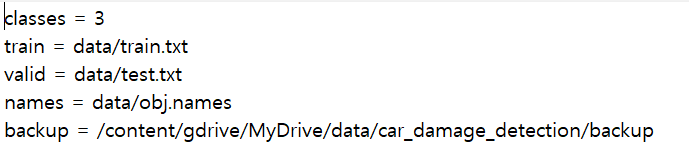





In [13]:
# 구글 드라이브에 obj.names와 obj.data를 넣어준 뒤 darknet/data 안에 복사해준다.
!cp /content/gdrive/MyDrive/data/car_damage_detection/obj.names ./data
!cp /content/gdrive/MyDrive/data/car_damage_detection/obj.data  ./data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

### iii) Generating train.txt

Train.txt 파일 만드는 코드 참조 [Github Repo](https://github.com/theAIGuysCode/YoloGenerateTrainingFile/blob/master/generate_train.py/)



In [ ]:
# 구글 드라이브에 업로드 후 darknet으로 가져오기
!cp /content/gdrive/MyDrive/data/car_damage_detection/generate_train.py ./

# upload the generate_train.py script to cloud VM from local machine (uncomment to use)
#upload()


Now we simply run the python script to do all the work for us.

In [ ]:
# darknet/data/obj 안에 이미지, txt 파일 넣어줘야 함
!python generate_train.py

In [ ]:
# verify train.txt can be seen in our darknet/data folder
!ls data/

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


**train.txt**은 아래 사진과 같이 생성된다.

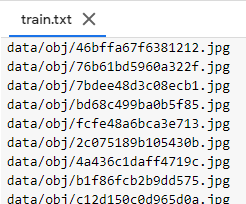


## Step 4: Download pre-trained weights for the convolutional layers.
Yolov3의 convolutional layers 가중치를 다운로드 한다. 이것이 우리의 custom data를 모델에 학습시킬 때 더 빠르고 정확하게 해줄 것이다. (사용하지 않아도 되지만 하는 것을 추천)

In [14]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

URL transformed to HTTPS due to an HSTS policy
--2021-07-21 14:16:01--  https://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  91.5MB/s    in 1.7s    

2021-07-21 14:16:03 (91.5 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



## Step 5: Train Your Custom Object Detector!
아래 커맨드를 입력하면 학습이 시작된다. (dont_show 는 cloud가 이미지를 열 수 없을 때 뜨는 팝업을 보이지 않게 해준다.)
```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```
**TIP:** 학습이 진행되는 동안 시간이 오래 걸릴 것이다. 이번 프로젝트 학습의 경우 약 6시간 정도 소요됐다. 하지만 코랩은 일정 시간 동안 반응이 없으면 연결이 끊긴다(약 30-90 mins).


이것을 방지하기 위해서 (CTRL + SHIFT + i) 를 누르고 아래 명령어를 입력하면 

```
function ClickConnect(){
console.log("Working"); 
document.querySelector("colab-toolbar-button#connect").click() 
}
setInterval(ClickConnect,60000)
```
10분마다 화면을 클릭해줘서 런타임이 끊기는 것을 방지할 수 있다.

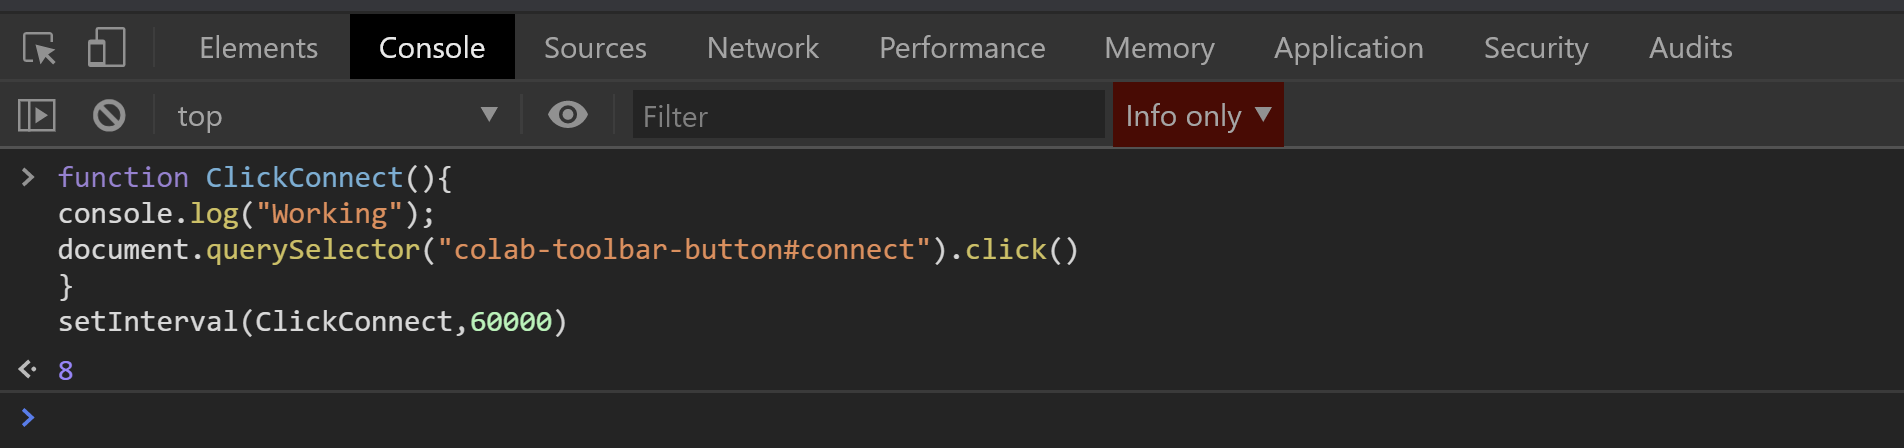

In [ ]:
# train your custom detector
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

chart.png 파일을 통해 average loss vs. iterations 차트를 확인할 수 있다. 2 이하의 loss를 얻기 위해 학습에 필요한 정도를 알 수 있음.

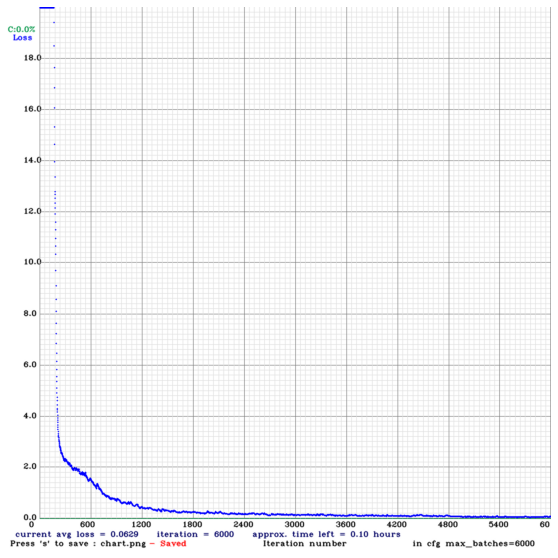

In [ ]:
imShow('chart.png')

**TRICK**:  **yolov3_custom_last.weights** 파일이 백업 경로인 **mydrive/yolov3/backup/** 에 저장될 것이다. 따라서 중단시켰다가 처음부터 다시 학습하지 않고 이어서 할 수 있다.

```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [ ]:
# 차량 파손 이미지 학습
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 total_bbox = 655244, rewritten_bbox = 0.000000 % 

 5926: 0.050354, 0.065962 avg loss, 0.000010 rate, 5.347372 seconds, 379264 images, 0.153593 hours left
Loaded: 0.000064 seconds
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.926610), count: 6, class_loss = 0.000055, iou_loss = 0.042864, total_loss = 0.042919 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.871028), count: 1, class_loss = 0.007637, iou_loss = 0.006113, total_loss = 0.013750 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.000000), count: 1, class_loss = 0.000000, iou_loss = 0.000000, total_loss = 0.000000 
 total_bbox = 655251, rewritten_bbox = 0.000000 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.860162), count: 6, class_loss = 0.003178, iou_loss = 0.086869, total_loss = 0.090047 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00)

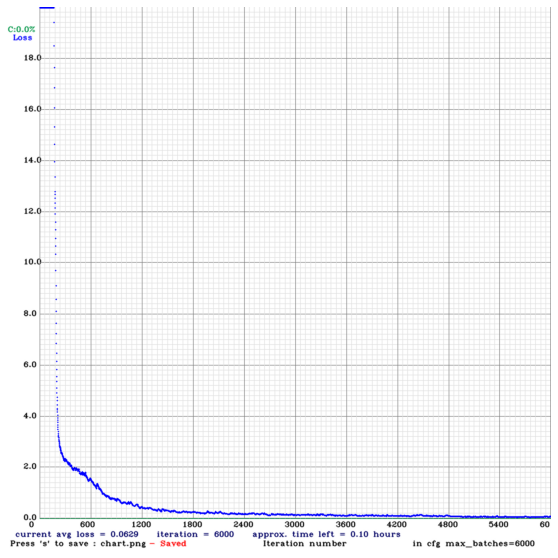

In [ ]:
imShow('chart_yolov3_custom.png')

# 학습된 모델로 차량 파손 예측하기


In [ ]:
# cutom.cfg 파일을 test모드로 바꿔준다.
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut

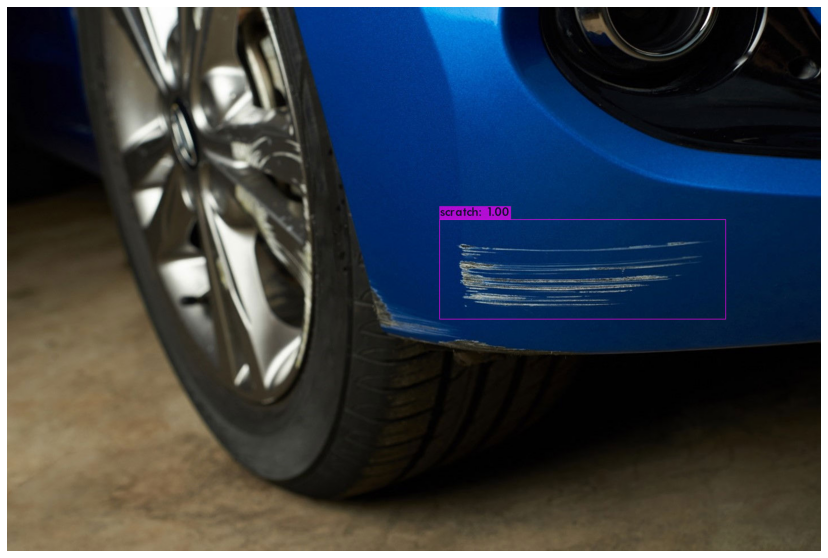

In [ ]:
# thresh flag sets accuracy that detection must be in order to show it -thresh 0.3
# Val file directory : /content/gdrive/MyDrive/data/car_damage_detection/obj/0027.jpeg
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/gdrive/MyDrive/data/car_damage_detection/backup/yolov3_custom_6000.weights data/Test1.jpg -thresh 0.3
imShow('predictions.jpg')

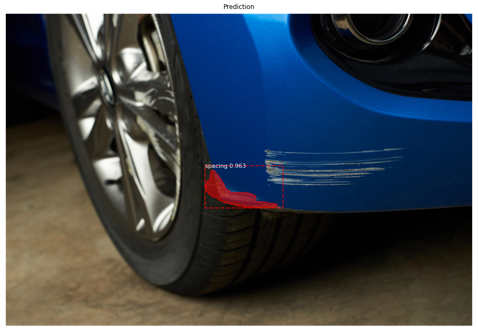 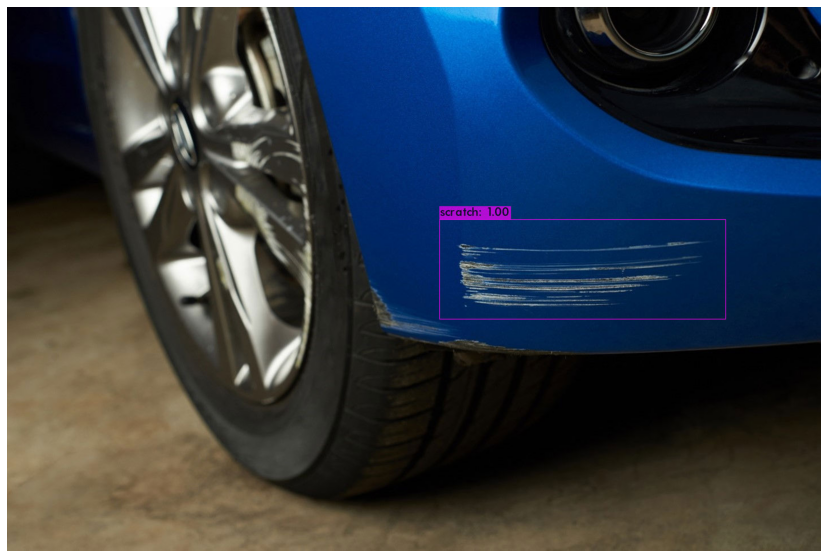

- mask r-cnn을 사용했을 때 잘못된 예측을 했던 이전의 결과와 달리(위의 사진), 정확한 부위에 정확한 예측을 했다. 성능이 개선되었음을 알 수 있음. 하지만 다른 부분은 탐지하지 못했다.

Train :

Image *.jpg

7 8 10 14 28 39 45 60 61 62 63 64 65 66 67 73 75 76 77 78 79 80

두 자리 숫자 *jpg

1 2 3 4 9 10 13 14 15 16 17 18 19 20 21 27 29 31 33 36 38 39 40 42 44 49 57 62 69 73 74 75 76 77 78 79

네 자리 숫자 *JPEG

0015 0017 0019 0029 0030 0032 0048 0075 0098 0109 0110 0115 0119 0123 0121 0124 0125 0126 0136 0138 0149 0179 0195 0198 0200 0216 0227 0241 0267 0269 0295 0353 0380 0386 0405 0454 0468 0476 0481 0485 0506 0525 0551 0572 0575 0579 0589 0610 0625 0658 0703 0745 0763 0773 0857 0861 0867 0871 0875 0881 0912


Test:

Image * jpg

1 6 9 46 59 72 74

두 자리 숫자 *jpg

59 64 68 

네 자리 숫자 *JPEG jpeg

0027 0127 0129 0157 0159 0493 0700 0816


- 쏘카의 경우, annotation을 mask r-cnn에서와 같이 poly형태로 했다고한다. 그렇게 했을 때 scratch와 spacing, dent를 내 기준으로 나눴기 때문에 조금 기준이 뚜렷하지 않게 됐을 수도 있다. 그리고 데이터셋 또한, 쏘카는 쏘카 자체에서 업로드 받은 사진을 이용했지만 나는 여러 데이터셋을 합쳐서 이용했기 때문에 이미지 통일성 부분도 문제가 된 것 같다.